In [2]:
pip install tensorflow==2.9


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 29.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-serve

In [12]:
import os
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, AdditiveAttention
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

In [2]:
# Paths to dataset
# dataset_path = "Flickr8k_Dataset"
captions_path = "hindi_captions.txt"

# Load captions
# Load captions and normalize keys
def load_captions(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        captions = file.readlines()
    captions_dict = {}
    for line in captions:
        image, caption = line.split('\t')
        # Normalize image key by removing suffixes like #4
        image = image.split('#')[0].strip()
        caption = caption.strip()
        caption = f"<start> {caption} <end>"
        if image not in captions_dict:
            captions_dict[image] = []
        captions_dict[image].append(caption)
    return captions_dict

captions_dict = load_captions(captions_path)


In [3]:
all_captions = [cap for caps in captions_dict.values() for cap in caps]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to tokenizer.pkl")

Tokenizer saved to tokenizer.pkl


In [1]:
# Tokenizer
all_captions = [cap for caps in captions_dict.values() for cap in caps]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to tokenizer.pkl")


vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(cap.split()) for cap in all_captions)

# Prepare sequences
def create_sequences(tokenizer, captions_dict, features_dict, max_length, vocab_size):
    X1, X2, y = [], [], []
    for image, captions in captions_dict.items():
        print(f"Processing image: {image}")  # Check if the image is being processed
        if image not in features_dict:
            print(f"Feature not found for image: {image}")  # Check if feature exists for the image
            continue  # Skip if feature is missing for the image
        for caption in captions:
            print(f"Processing caption: {caption}")  # Check if caption is being processed
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # Ensure that features are flattened into a 1D array of shape (2048,)
                features = features_dict[image]
                if len(features.shape) > 1:
                    features = features.flatten()  # Flatten if needed to ensure it's (2048,)

                X1.append(features)
                X2.append(in_seq)
                y.append(out_seq)

    print(f"X1 length: {len(X1)}")  # Check if data is added to X1
    print(f"X2 length: {len(X2)}")  # Check if data is added to X2
    print(f"y length: {len(y)}")    # Check if data is added to y

    return np.array(X1), np.array(X2), np.array(y)


# After extracting features, make sure they are flattened
import numpy as np

# Load the precomputed features
image_features = np.load('image_features.npy', allow_pickle=True)

# If the features are stored in a dictionary-like format
# Ensure that you are loading the data correctly into a dictionary.
# Assuming the file contains a dictionary of features
features_dict = {image_name: feature for image_name, feature in image_features.item().items()}

# Check the loaded features
print(f"Loaded features: {list(features_dict.keys())[:5]}")


# Now call create_sequences
X1, X2, y = create_sequences(tokenizer, captions_dict, features_dict, max_length, vocab_size)




NameError: name 'captions_dict' is not defined

In [ ]:
# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# Encoder-Decoder Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Add, Reshape
from tensorflow.keras.models import Model

def build_model(vocab_size, max_length, embedding_dim=256, units=256):
    # Feature input and processing
    features_input = Input(shape=(2048,))
    features_dense = Dense(units, activation="relu")(features_input)
    # Use Reshape to add an additional dimension
    features_reshaped = Reshape((1, units))(features_dense)

    # Caption input and processing
    caption_input = Input(shape=(max_length,))
    caption_embed = Embedding(vocab_size, embedding_dim, mask_zero=True)(caption_input)
    caption_lstm = LSTM(units, return_sequences=True)(caption_embed)

    # Combine features and captions
    combined = Add()([features_reshaped, caption_lstm])
    combined_lstm = LSTM(units)(combined)
    combined_dense = Dense(units, activation="relu")(combined_lstm)
    outputs = Dense(vocab_size, activation="softmax")(combined_dense)

    # Build the model
    model = Model(inputs=[features_input, caption_input], outputs=outputs)
    return model

# Build and compile the model
model = build_model(vocab_size, max_length)
model.compile(optimizer="adam", loss="categorical_crossentropy")



In [ ]:
print("Shape of X1:", X1.shape)  # Should be (num_samples, 2048)
print("Shape of X2:", X2.shape)  # Should be (num_samples, max_length)
print("Shape of y:", y.shape)    # Should be (num_samples, vocab_size)

Shape of X1: (543063, 2048)
Shape of X2: (543063, 47)
Shape of y: (543063, 8688)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

checkpoint = ModelCheckpoint("best_model.h5",
                             monitor="val_loss",  # Monitor training loss
                             save_best_only=True,
                             mode="min",
                             verbose=1)

# Train the model without validation data
model.fit([X1_train, X2_train], y_train,
          validation_data=([X1_val, X2_val], y_val),
          epochs=10,
          batch_size=64,
          callbacks=[checkpoint])


Epoch 1/10
8486/8486 [==============================] - ETA: 0s - loss: 2.7739
Epoch 1: loss improved from inf to 2.77392, saving model to best_model.h5
8486/8486 [==============================] - 2096s 247ms/step - loss: 2.7739
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8486/8486 [==============================] - ETA: 0s - loss: 2.6540
Epoch 2: loss improved from 2.77392 to 2.65397, saving model to best_model.h5
8486/8486 [==============================] - 2090s 246ms/step - loss: 2.6540
Epoch 3/10
8486/8486 [==============================] - ETA: 0s - loss: 2.5703
Epoch 3: loss improved from 2.65397 to 2.57029, saving model to best_model.h5
8486/8486 [==============================] - 2090s 246ms/step - loss: 2.5703
Epoch 4/10
4936/8486 [================>.............] - ETA: 14:34 - loss: 2.4805

In [5]:
from tensorflow.keras.models import load_model

# Load model without the optimizer
capmodel = load_model("best_model.h5", compile=False)

# Compile the model again with a valid optimizer
from tensorflow.keras.optimizers import Adam
capmodel.compile(optimizer=Adam(), loss="categorical_crossentropy")


In [6]:
# Paths to dataset
# dataset_path = "Flickr8k_Dataset"
captions_path = "hindi_captions.txt"

# Load captions
# Load captions and normalize keys
def load_captions(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        captions = file.readlines()
    captions_dict = {}
    for line in captions:
        image, caption = line.split('\t')
        # Normalize image key by removing suffixes like #4
        image = image.split('#')[0].strip()
        caption = caption.strip()
        caption = f"<start> {caption} <end>"
        if image not in captions_dict:
            captions_dict[image] = []
        captions_dict[image].append(caption)
    return captions_dict

captions_dict = load_captions(captions_path)


In [7]:
all_captions = [cap for caps in captions_dict.values() for cap in caps]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to tokenizer.pkl")

Tokenizer saved to tokenizer.pkl


In [8]:
def extract_features(img_path):
    model = InceptionV3(weights="imagenet", include_top=False, pooling="avg")
    # features = {}
    img = load_img(img_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return model.predict(img)

In [ ]:
tokenizer = Tokenizer()
# feature_extractor = extract_features()

In [10]:
max_length = 47

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def preview_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

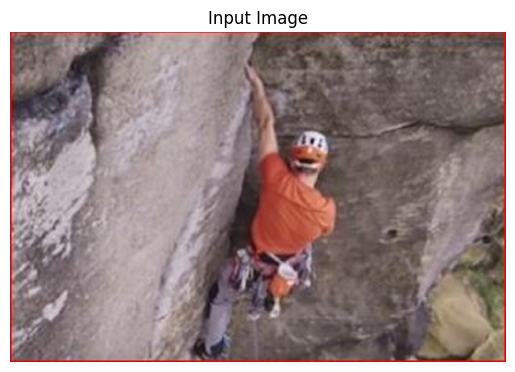

1/1 [==============================] - 2s 2s/step
Generated Caption: <start> एक आदमी एक चट्टान पर चढ़ता है।


In [11]:
def generate_caption(model, tokenizer, features, max_length):
    caption = "<start>"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = model.predict([features, sequence], verbose=0)
        predicted_index = np.argmax(prediction)

        # Handle missing keys
        predicted_word = tokenizer.index_word.get(predicted_index, "<unknown>")

        if predicted_word == "end":
            break
        caption += " " + predicted_word
    return caption

# Test on an image
test_image = "blind.jpg"
preview_image(test_image)
test_features = extract_features(test_image)
caption = generate_caption(capmodel, tokenizer, test_features, max_length)
print("Generated Caption:", caption)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from PIL import Image
import os

class CaptioningTransformer(nn.Module):
    def __init__(self, vocab_size, feature_dim=2048, hidden_size=768, num_heads=8, num_layers=6, max_len=max_length):
        super(CaptioningTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # Positional encodings are initialized dynamically for max_len
        self.max_len = max_len
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, hidden_size))

        # Projection layer to match feature_dim to hidden_size (d_model)
        self.feature_projection = nn.Linear(feature_dim, hidden_size)

        self.transformer = nn.Transformer(
            d_model=hidden_size,
            nhead=num_heads,
            num_encoder_layers=6,
            num_decoder_layers=num_layers,
        )
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, img_features, captions):
        batch_size, seq_len = captions.size()

        # Flatten the image features to (batch_size, feature_dim)
        img_features = img_features.view(img_features.size(0), -1)  # (batch_size, feature_dim)

        # Project the image features to match the hidden size (d_model)
        img_features = self.feature_projection(img_features).unsqueeze(0)  # (1, batch_size, hidden_size)

        # Add positional encodings to captions (dynamically slicing based on caption length)
        captions_emb = self.embedding(captions) + self.positional_encoding[:, :seq_len, :]

        # Ensure that both src and tgt have the same batch size
        img_features = img_features.expand(-1, batch_size, -1)  # (1, batch_size, hidden_size)
        captions_emb = captions_emb.permute(1, 0, 2)  # (seq_len, batch_size, hidden_size)

        # Pass through the Transformer
        transformer_out = self.transformer(img_features, captions_emb)

        # Output layer
        out = self.fc_out(transformer_out.permute(1, 0, 2))  # (batch_size, seq_len, vocab_size)
        return out



# Initialize the model
vocab_size = tokenizer.vocab_size - 1
caption_model = CaptioningTransformer(vocab_size)



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ImageCaptionDataset(Dataset):
    def __init__(self, features_dict, captions_dict, tokenizer, max_len=max_length):
        self.features = features_dict
        self.captions = captions_dict
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
      image = list(self.features.keys())[idx]

      # Check if the image exists in captions
      if image not in self.captions:
          print(f"Warning: Caption for image {image} not found.")
          # Return empty or default values for missing captions
          return self.features[image], torch.zeros(max_length, dtype=torch.long), torch.zeros(max_length, dtype=torch.long)

      features = self.features[image]
      captions = self.captions[image][0]  # Use the first caption for simplicity

      # Tokenize captions using encode_plus
      inputs = tokenizer.encode_plus(
          captions,
          add_special_tokens=True,
          padding='max_length',
          truncation=True,
          max_length=max_length,
          return_tensors="pt"
      )

      input_ids = inputs['input_ids'].squeeze(0).long()  # Ensure LongTensor type
      attention_mask = inputs['attention_mask'].squeeze(0).long()  # Ensure LongTensor type

      return features, input_ids, attention_mask




# Create DataLoader
dataset = ImageCaptionDataset(features_dict, captions_dict, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [ ]:
from transformers import BertTokenizer

# Load mBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Tokenize captions (check padding length)
def tokenize_captions(captions_dict, tokenizer, max_len=max_length):
    tokenized_captions = {}
    for image, captions in captions_dict.items():
        tokenized_captions[image] = [
            tokenizer(
                caption, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
            )
            for caption in captions
        ]
    return tokenized_captions

tokenized_captions = tokenize_captions(captions_dict, tokenizer)
print(f"Tokenized captions for {len(tokenized_captions)} images.")


Tokenized captions for 8091 images.


In [ ]:
import os

# Directory to save checkpoints
# checkpoint_dir = './checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")

# Example: Saving checkpoint after each epoch
for epoch in range(10):
    epoch_loss = 0
    for img_features, captions, masks in dataloader:
        optimizer.zero_grad()

        outputs = caption_model(img_features, captions[:, :-1])
        loss = loss_fn(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Save checkpoint after each epoch
    save_checkpoint(caption_model, optimizer, epoch, epoch_loss / len(dataloader))
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(dataloader)}")


In [ ]:
import torch

# Assuming the model and optimizer are defined as before

def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filename}")
    return model, optimizer, epoch, loss

# Load the model and optimizer state from checkpoint
caption_model, optimizer, epoch, loss = load_checkpoint(caption_model, optimizer, 'checkpoint.pth')
caption_model.eval()  # Set model to evaluation mode


<ipython-input-110-c72cdadd2a84>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from checkpoint.pth


CaptioningTransformer(
  (embedding): Embedding(119546, 768)
  (feature_projection): Linear(in_features=2048, out_features=768, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): Transform

In [ ]:
def generate_caption_MHA(img_features, model, tokenizer, max_len):
    """
    Generates a caption for the given image using the MHA model.
    """
    model.eval()
    device = next(model.parameters()).device  # Ensure the model is on the correct device
    img_features = img_features.unsqueeze(0).to(device)  # Add batch dimension for a single image

    # Start token (assuming <start> is the first token in the vocabulary)
    caption = ["<start>"]

    for _ in range(max_len):
        tokenized = tokenizer(" ".join(caption), return_tensors="pt", padding=True, truncation=True).to(device)

        # Pass image features and current caption to the model
        with torch.no_grad():
            output = model(img_features, tokenized["input_ids"])  # Model returns logits

        # Get the predicted token (greedy search: pick the token with the highest score)
        next_token = torch.argmax(output[:, -1, :], dim=-1)  # Shape: (1,)
        next_token = next_token.item()  # Convert tensor to scalar

        # Decode token to word
        next_word = tokenizer.decode([next_token])

        # Stop if the end token is predicted
        if next_word == "<end>":
            break

        # Add the predicted word to the caption
        caption.append(next_word)

    # Return the generated caption without start and end tokens
    return " ".join(caption[1:])  # Exclude <start>


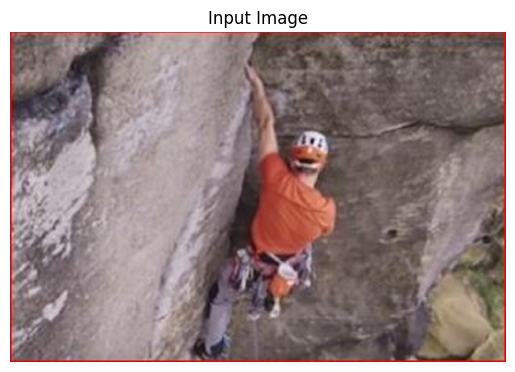

1/1 [==============================] - 1s 1s/step
Generated Caption: <start> एक आदमी एक चट्टान पर चढ़ता है।


In [ ]:
test_image = "blind.jpg"
preview_image(test_image)
test_image_features = extract_features(test_image)
mha_caption = generate_caption(capmodel, tokenizer, test_image_features, max_length)
print("Generated Caption:", mha_caption)